<a href="https://colab.research.google.com/github/usneek/sequence-embeddings/blob/main/Attributed_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code file constructs embeddings taking into account attributes along with sequences. The cell state of last LSTM cell can be used as an embedding vector.

# **Importing**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Lambda,RepeatVector,Reshape
from tensorflow.keras import Model
from __future__ import print_function
import IPython
import sys

# **Data Preprocessing**

1. To convert date of logs in YYYY-MM-DD fromat so they can be sorted in chronological order.
2. Next step is to fill empty cells in the column ModuleCode with Assessment Code
3. First attribute will be activity score. To calculate the ActivityScore we assign weights to each activity: [Study:1, Quiz:1.15, Test: 1.25]
4. Then for each user we will create list of activities they attempted in order of date i.e. the sequence of activities.
5. Another attributes to be extracted for user can be their avrage score and total time spent in the entire duration of course.
4. Then we will remove those columns which don't have complete information about them i.e. if they passed or failed the course.
5. Then we will use LabelEncoder() to label the output values.
6. Finally we split the data into train, validation and test set in 3:1:1

In [ ]:
corpus=pd.read_csv("drive/MyDrive/Data/course_usage_anon.csv")
corpus['AttemptDate']=pd.to_datetime(corpus['AttemptDate'])
corpus=corpus.sort_values(by="AttemptDate")
corpus['ActivityType'] = corpus['ActivityType'].replace(['Study'],1)
corpus['ActivityType'] = corpus['ActivityType'].replace(['Quiz'],1.15)
corpus['ActivityType'] = corpus['ActivityType'].replace(['PracticeTest'],1.25)
corpus['ModuleCode'] = corpus['ModuleCode'].fillna(corpus['AssessmentCode'])
corpus['CumulativeTotalStudyTimespentInSec']=corpus['CumulativeTotalStudyTimespentInSec'].fillna(corpus['CumulativeExamTimespentInSec'])

In [ ]:
x1=corpus.groupby(by="UserID")["ModuleCode"].apply(list)
x1=x1.reset_index(name="sequence")
x1.columns=["id","sequence"]

x2=corpus.groupby(by="UserID")["ActivityType"].sum()
x2=x2.reset_index(name="ActivityScore")
x2.columns=["id","ActivityScore"]

x3=corpus.groupby(by="UserID", dropna=True)["CumulativeExamScore"].mean()
x3=x3.reset_index(name="CumulativeExamScore")
x3.columns=["id","CumulativeExamScore"]
x3=x3.dropna(subset=["CumulativeExamScore"])

x4=corpus.groupby(by="UserID", dropna=True)["CumulativeTotalStudyTimespentInSec"].sum()
x4=x4.reset_index(name="CumulativeTotalStudyTimespentInSec")
x4.columns=["id","CumulativeTotalStudyTimespentInSec"]
x4=x4.dropna(subset=["CumulativeTotalStudyTimespentInSec"])

corpus=corpus.dropna(subset=["PassFail"])
x5=corpus.groupby(by="UserID")["PassFail"].mean()
x5=x5.reset_index(name="PassFail")
x5.columns=["id","PassFail"]


In [ ]:
corpus=x1.join(x5,rsuffix='id',how="inner")
corpus=corpus.join(x2,rsuffix='id',how="inner")
corpus=corpus.join(x3,rsuffix='id',how="inner")
corpus=corpus.join(x4,rsuffix='id',how="inner")
corpus["Attribute"]=corpus["ActivityScore"].apply(lambda x:[x])+corpus['CumulativeTotalStudyTimespentInSec'].apply(lambda x:[x])+corpus['CumulativeExamScore'].apply(lambda x:[x])
corpus['Attribute'] = corpus['Attribute'].map(list)

In [ ]:

corpus=corpus.drop([ 'idid', 'idid', 'ActivityScore', 'idid','CumulativeExamScore', 'idid', 'CumulativeTotalStudyTimespentInSec',], axis=1)

In [ ]:

x_train,x_test=train_test_split(corpus,test_size=0.2,random_state=0)
x_train,x_val=train_test_split(x_train,test_size=0.2,random_state=0)

# **Extracting attributed Embeddings**

First we need to process our input and output for sequence model. The inpout
and output is same except the output is one step left if input since we need to predict the next state from the previous states.



In [ ]:
def rotate(l, n):
    return l[n:] + l[:n]

In [ ]:
X=x_train['sequence']
L=[]
for i in X:
  j=rotate(i,1)
  L.append(j)
x_train["changed"]=L

Y=x_train["changed"]
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words =25, split=',')
tokenizer.fit_on_texts(X)
seqs = tokenizer.texts_to_sequences(X)
pad_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 30)
final_X=tf.one_hot(pad_seqs,25)

seqs_Y = tokenizer.texts_to_sequences(Y)
pad_seqs_Y = tf.keras.preprocessing.sequence.pad_sequences(seqs_Y, 30)
final_Y=tf.one_hot(pad_seqs_Y,25)

X_val=x_val['sequence']
L=[]
for i in X_val:
  j=rotate(i,1)
  L.append(j)
x_val["changed"]=L

Y_val=x_val["changed"]
seqs_val = tokenizer.texts_to_sequences(X_val)
pad_seqs_val = tf.keras.preprocessing.sequence.pad_sequences(seqs_val, 30)
final_X_val=tf.one_hot(pad_seqs_val,25)

seqs_Y_val = tokenizer.texts_to_sequences(Y_val)
pad_seqs_Y_val = tf.keras.preprocessing.sequence.pad_sequences(seqs_Y_val, 30)
final_Y_val=tf.one_hot(pad_seqs_Y_val,25)

Defining global varibles:-
1. n_values is for number of differnt possible events that exist.
2. n_a is for the dimension of LSTM layer.
3. m is no of examples in our training set

In [ ]:
n_values=25
n_a=3
m=2983

**Defining layers of our Sequential model**

In [ ]:
reshapor = Reshape((1,n_values))
LSTM_cell = LSTM(n_a, return_state = True)         
densor = Dense(n_values, activation='softmax')     

**Extracting attribute vector which consists of:-
Activity Score, Exam score and Total time spent**

In [ ]:
to_be_add=x_train["Attribute"]
pad_to_be_add = tf.keras.preprocessing.sequence.pad_sequences(to_be_add, 3)
to_be_add_val=x_val["Attribute"]
pad_to_be_add_val = tf.keras.preprocessing.sequence.pad_sequences(to_be_add_val, 3)

**Defining the Sequence Model**
Model will be used for training the layers and output will be later extracted from model_out

In [ ]:
def embedd_model(Tx, n_a, n_values):
    X= Input(shape=(Tx,n_values))
    a0 = Input(shape=(n_a,))
    c0 = Input(shape=(n_a,))
    a = a0
    c = c0
    outputs = []
    for t in range(Tx): 
        x=X[:,t,:]
        x=reshapor(x)
        a,_, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
    model_0=Model(inputs=[X, a0, c0], outputs=c)
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    return model,model_0

In [ ]:
model,model_0=embedd_model(Tx=30,n_a=3,n_values=25)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Initial state of LSTM cell:-
Hidden state:- **Attribute vector will be passed to it**

Cell state:- Initialised to Zero

In [ ]:
a0 = np.zeros((m, n_a))
a0=np.add(pad_to_be_add,a0)
c0 = np.zeros((m, n_a))
a_val = np.zeros((746, n_a))
a_val=np.add(pad_to_be_add_val,a_val)
c_val = np.zeros((746, n_a))

In [ ]:
final_X=np.reshape(final_X,(2983,30,25))
final_Y=np.reshape(final_Y,(30,2983,25))
final_X_val=np.reshape(final_X_val,(746,30,25))
final_Y_val=np.reshape(final_Y_val,(30,746,25))

**Excecuting our LSTM sequential Model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(filepath='drive/MyDrive/Data/Attributed/model.{epoch:02d}-{val_loss:.2f}.h5',
                                            save_weights_only = True,
                                            verbose = 1,
                                            save_best_only=False)
history=model.fit([final_X, a0, c0], list(final_Y), validation_data=([final_X_val,a_val,c_val],list(final_Y_val)),epochs=100,batch_size=128,callbacks=[model_checkpoint_callback])

Epoch 1/100
24/24 [==============================] - 1s 53ms/step - loss: 64.9097 - dense_loss: 2.3562 - dense_1_loss: 2.1477 - dense_2_loss: 2.1073 - dense_3_loss: 2.0669 - dense_4_loss: 2.0448 - dense_5_loss: 2.1281 - dense_6_loss: 2.2964 - dense_7_loss: 2.1727 - dense_8_loss: 2.0318 - dense_9_loss: 2.1196 - dense_10_loss: 2.1314 - dense_11_loss: 2.3463 - dense_12_loss: 2.0324 - dense_13_loss: 2.2076 - dense_14_loss: 2.1337 - dense_15_loss: 1.9898 - dense_16_loss: 2.3218 - dense_17_loss: 2.1156 - dense_18_loss: 2.2076 - dense_19_loss: 2.2742 - dense_20_loss: 2.0623 - dense_21_loss: 2.1600 - dense_22_loss: 2.3391 - dense_23_loss: 2.3230 - dense_24_loss: 1.8878 - dense_25_loss: 2.3231 - dense_26_loss: 2.4623 - dense_27_loss: 2.1392 - dense_28_loss: 1.9119 - dense_29_loss: 2.0691 - dense_accuracy: 0.4519 - dense_1_accuracy: 0.5139 - dense_2_accuracy: 0.5226 - dense_3_accuracy: 0.5377 - dense_4_accuracy: 0.5444 - dense_5_accuracy: 0.5176 - dense_6_accuracy: 0.4626 - dense_7_accuracy: 0.5

**Plotting training and validation loss to decide the epoch number after which weights should be taken**

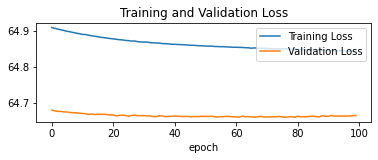

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Choosing weight of 80th epoch**

In [ ]:
model.load_weights('drive/MyDrive/Data/Attributed/model.80-64.66.h5')

**Final Embeddings Generated**

In [ ]:
embeddings=model_0.predict([final_X,a0,c0])
embeddings_val=model_0.predict([final_X_val,a_val,c_val])

# **Evaluation**

1. We will train a classifier in keras to predict the output of each sequence embedding as pass/fail.
2. We will predict our accuracy and F1 score on test set to measure the efficeincy of our embeddings

In [ ]:
y_train=x_train["PassFail"]
y_val=x_val["PassFail"]

In [ ]:
classifier = Sequential()
classifier.add(Dense(64, input_shape = (embeddings.shape[1],))) 
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [ ]:
model_checkpoint_callback = ModelCheckpoint(filepath='drive/MyDrive/Data/Attributed/model.{epoch:02d}-{val_loss:.2f}.h5',
                                            save_weights_only = True,
                                            verbose = 1,
                                            save_best_only=False)
history=classifier.fit(embeddings, y_train ,validation_data=(embeddings_val,y_val),batch_size=128, epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
24/24 [==============================] - 0s 3ms/step - loss: 1.1356 - accuracy: 0.6400 - val_loss: 0.5712 - val_accuracy: 0.7426

Epoch 00001: saving model to drive/MyDrive/Data/Attributed/model.01-0.57.h5
Epoch 2/30
24/24 [==============================] - 0s 3ms/step - loss: 0.8501 - accuracy: 0.6624 - val_loss: 0.6352 - val_accuracy: 0.7426

Epoch 00002: saving model to drive/MyDrive/Data/Attributed/model.02-0.64.h5
Epoch 3/30
24/24 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.6597 - val_loss: 0.7083 - val_accuracy: 0.2614

Epoch 00003: saving model to drive/MyDrive/Data/Attributed/model.03-0.71.h5
Epoch 4/30
24/24 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6933 - val_loss: 0.6698 - val_accuracy: 0.7426

Epoch 00004: saving model to drive/MyDrive/Data/Attributed/model.04-0.67.h5
Epoch 5/30
24/24 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.7271 - val_loss: 0.6474 - val_accuracy:

**Plotting training and validation loss to decide the epoch number after which weights should be taken**

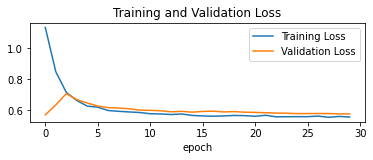

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Deciding 27 as the epoch number**

In [ ]:
classifier.load_weights('drive/MyDrive/Data/Attributed/model.27-0.58.h5')

**Predicting the test score**

In [ ]:
m_test=933
final_X_test=x_test["sequence"]
seqs_test = tokenizer.texts_to_sequences(final_X_test)
pad_seqs_test = tf.keras.preprocessing.sequence.pad_sequences(seqs_test, 30)
final_X_test=tf.one_hot(pad_seqs_test,25)
to_be_add_test=x_test["Attribute"]
pad_to_be_add_test = tf.keras.preprocessing.sequence.pad_sequences(to_be_add_test, 3)
a_test = np.zeros((m_test, n_a))
a_test=np.add(pad_to_be_add_test,a_test)
c_test = np.zeros((m_test, n_a))
embedding_test=model_0.predict([final_X_test,a_test,c_test])

In [ ]:
y_test=x_test["PassFail"]
predictions=classifier.predict(embedding_test)
rounded=[round(x[0]) for x in predictions]

In [ ]:
acc=accuracy_score(rounded,y_test)
f1=f1_score(y_test, rounded)
print("Accuracy is ",acc)
print("f1 score is ",f1)

Accuracy is  0.7706323687031083
f1 score is  0.8704600484261501
